Load necessary imports

In [1]:
from metrics import Evaluate
from models import VectorSpaceModel, LMJM
from letor import LETOR, loadDataset
from os.path import exists

import data_loading as d_load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [ ]:
if (exists('train_data.obj') and 
    exists('test_data.obj') and 
    exists('trials_data.obj')):
    
    #load the objects from pickle
    file_data = open('train_data.obj', 'rb') 
    train = pickle.load(file_data)
    file_data.close()
    
    file_data = open('test_data.obj', 'rb') 
    test = pickle.load(file_data)
    file_data.close()
    
    file_data = open('trials_data.obj', 'rb') 
    trials = pickle.load(file_data)
    file_data.close()

else:
    
    train, test = d_load.load_and_split_queries()
    trials = d_load.load_evaluated_trials()

    #Save the data objects to files
    file_data = open('train_data.obj', 'wb') 
    pickle.dump(train, file_data)
    file_data.close()

    file_data = open('test_data.obj', 'wb') 
    pickle.dump(test, file_data)
    file_data.close()

    file_data = open('trials_data.obj', 'wb') 
    pickle.dump(trials, file_data)
    file_data.close()

VSM models' comparison to choose the best baselines

In [10]:
baselines = [{'lemmatization': False, 'bigrams': False, 'stopwords': None},
             {'lemmatization': True, 'bigrams': False, 'stopwords': None},
             {'lemmatization': False, 'bigrams': True, 'stopwords': None},
             {'lemmatization': True, 'bigrams': False, 'stopwords': 'english'},
             {'lemmatization': False, 'bigrams': False, 'stopwords': 'english'}]

sections = ['description', 'brief_summary', 'criteria']

baseline_metrics = pd.DataFrame(data=None, columns = ['11-point-precision', '11-point-recall',
                                                     'se-precision', 'se-recall'])
i = 0
for section in sections:
    for idx, baseline in enumerate(baselines):
        lmjm_model = VectorSpaceModel(trials, lowercase = True, section = section, 
                                        bigrams = baseline['bigrams'],
                                        lemmatize = baseline['lemmatization'],
                                        stopwords = baseline['stopwords'])
    
        df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    
        for query in train:
            search_results = lmjm_model.get_top_query_results(query.query_content)
            eval = Evaluate(query, search_results)
    
            df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                              eval.mrr, eval.precision_11point, eval.recall_11point]

        df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                     df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                     df_metrics['MRR'].mean(), 
                                     np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                     np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
        print(section)
        print(baseline)
        print(df_metrics.loc['average'])
    i += 1

description
{'lemmatization': False, 'bigrams': False, 'stopwords': None}
P@10                                                           0.114894
recall                                                           0.3236
AP                                                             0.080404
NDCG5                                                          0.105474
MRR                                                            0.005035
11-point-precision    [0.282343886651406, 0.21341736723642432, 0.129...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object
description
{'lemmatization': True, 'bigrams': False, 'stopwords': None}
P@10                                                           0.106383
recall                                                         0.331918
AP                                                             0.080523
NDCG5                                                          0.110494
MRR                             

Tuning lambda

In [ ]:
for section in ['description', 'brief_summary', 'criteria']:
    P10 = []
    Recall = []
    for l in np.arange(0.1, 1, 0.1):
        df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                                   '11-point-precision', '11-point-recall'])
        lmjm_model = LMJM(trials, arg_lambda = l, lowercase = True, lemmatize = False, section = section)
    
        for query in train:
            search_results = lmjm_model.get_top_query_results(query.query_content)
            eval = Evaluate(query, search_results)
        
            df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                          eval.mrr, eval.precision_11point, eval.recall_11point]
        
        df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                 df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                 df_metrics['MRR'].mean(), 
                                 np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                 np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
        P10.append(df_metrics.loc['average']['P@10'])
        Recall.append(df_metrics.loc['average']['recall'])
                  
    plt.plot(np.arange(0.1, 1, 0.1), P10, 'ro')
    plt.plot(np.arange(0.1, 1, 0.1), Recall, 'bo')
    plt.xlabel('Lambda')
    plt.title('P@10 and recall@100 vs lambda', fontweight='bold')
    plt.legend(['P@10', 'Recall'])
    plt.show()

Tuning lambda in smaller lambda range

In [ ]:
P10 = []
Recall = []
for l in np.arange(0.0, 0.21, 0.02):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    lmjm_model = LMJM(trials, arg_lambda = l, lowercase = True, lemmatize = False,
                      section='description')
    
    for query in train:
        search_results = lmjm_model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
        
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]
        
    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    P10.append(df_metrics.loc['average']['P@10'])
    Recall.append(df_metrics.loc['average']['recall'])
                  
plt.plot(np.arange(0.0, 0.21, 0.02), P10, 'ro')
plt.plot(np.arange(0.0, 0.21, 0.02), Recall, 'bo')
plt.xlabel('Lambda')
plt.title('P@10 and recall vs lambda', fontweight='bold')
plt.legend(['P@10', 'Recall'])

In [ ]:
P10 = []
Recall = []
for l in np.arange(0.0, 0.21, 0.02):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    lmjm_model = LMJM(trials, arg_lambda = l, lowercase = True, lemmatize = False,
                      section='description')
    
    for query in train:
        search_results = lmjm_model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
        
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]
        
    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    P10.append(df_metrics.loc['average']['P@10'])
    Recall.append(df_metrics.loc['average']['recall'])
                  
plt.plot(np.arange(0.0, 0.21, 0.02), P10, 'ro')
plt.plot(np.arange(0.0, 0.21, 0.02), Recall, 'bo')
plt.xlabel('Lambda')
plt.title('P@10 and recall vs lambda', fontweight='bold')
plt.legend(['P@10', 'Recall'])

In [ ]:
P10 = []
Recall = []
for l in np.arange(0.0, 0.31, 0.02):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    lmjm_model = LMJM(trials, arg_lambda = l, lowercase = True, lemmatize = False,
                      section='criteria')
    
    for query in train:
        search_results = lmjm_model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
        
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]
        
    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    P10.append(df_metrics.loc['average']['P@10'])
    Recall.append(df_metrics.loc['average']['recall'])
                  
plt.plot(np.arange(0.0, 0.31, 0.02), P10, 'ro')
plt.plot(np.arange(0.0, 0.31, 0.02), Recall, 'bo')
plt.xlabel('Lambda')
plt.title('P@10 and recall vs lambda', fontweight='bold')
plt.legend(['P@10', 'Recall'])

Training classifiers

C:\Users\user\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:

1
Train: 
[[8716.    0.]
 [3432.    0.]]
Valid:
[[2179.    0.]
 [ 858.    0.]]
2
Train: 
[[8249.  467.]
 [2919.  513.]]
Valid:
[[2060.  119.]
 [ 741.  117.]]
3
Train: 
[[8423.  293.]
 [2881.  551.]]
Valid:
[[2100.   79.]
 [ 736.  122.]]
4
Train: 
[[8439.  277.]
 [2852.  580.]]
Valid:
[[2084.   95.]
 [ 742.  116.]]
5
Train: 
[[8367.  349.]
 [2613.  819.]]
Valid:
[[2045.  134.]
 [ 694.  164.]]
6
Train: 
[[8470.  246.]
 [2609.  823.]]
Valid:
[[2050.  129.]
 [ 706.  152.]]
7
Train: 
[[8421.  295.]
 [2398. 1034.]]
Valid:
[[2004.  175.]
 [ 690.  168.]]
8
Train: 
[[8428.  288.]
 [2246. 1186.]]
Valid:
[[1966.  213.]
 [ 675.  183.]]
9
Train: 
[[8453.  263.]
 [2053. 1379.]]
Valid:
[[1921.  258.]
 [ 667.  191.]]
10
Train: 
[[8526.  190.]
 [1895. 1537.]]
Valid:
[[1917.  262.]
 [ 662.  196.]]
11
Train: 
[[8504.  212.]
 [1621. 1811.]]
Valid:
[[1849.  330.]
 [ 645.  213.]]
12
Train: 
[[8550.  166.]
 [1463. 1969.]]
Valid:
[[1823.  356.]
 [ 640.  218.]]
13
Train: 
[[8575.  141.]
 [1287. 2145.]]
Valid:


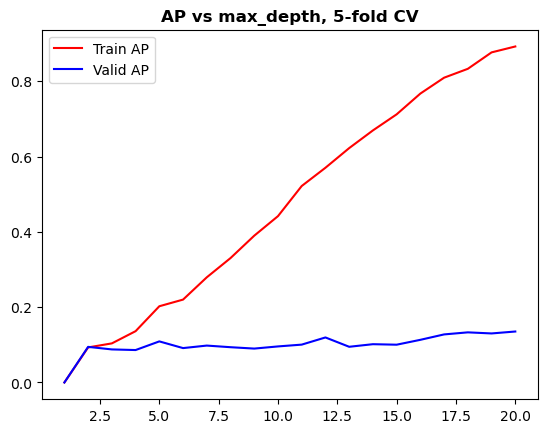

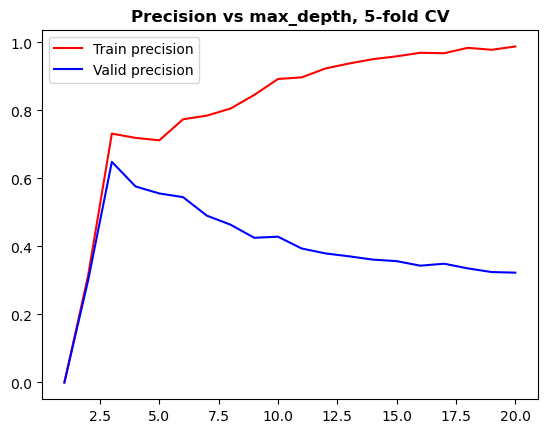

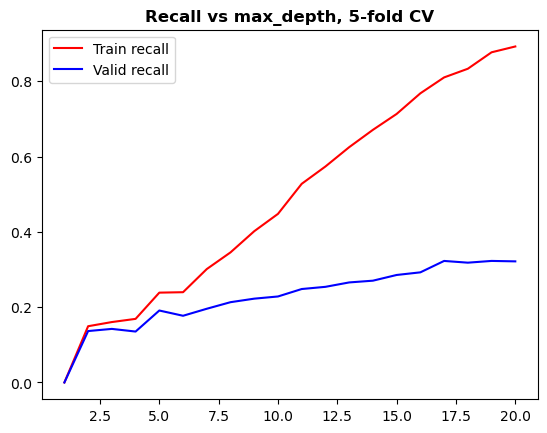

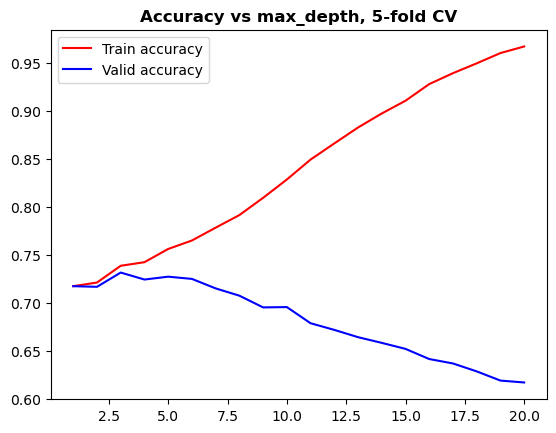

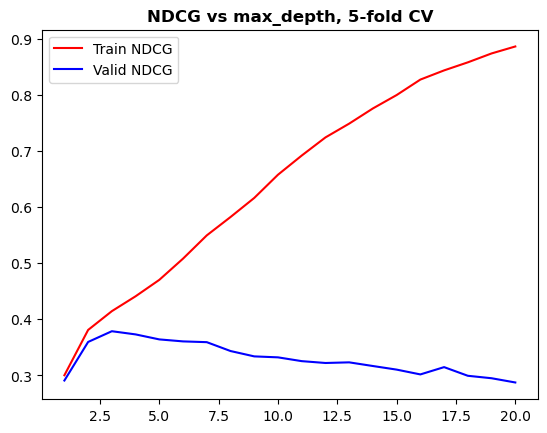

0.08778812240966181
0.3787876262085468


In [15]:
# Model 1 - no weights adjustment
dataset = loadDataset()

depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

train_ap = []
valid_ap = []

train_precision = []
valid_precision = []

train_recall = []
valid_recall = []

train_acc = []
valid_acc = []

train_ndcg = []
valid_ndcg = []

for d in depth:
    letor_model = LETOR(dataset, trials, class_weight=None, sample_weight=None, max_d = d)
    metrics, confusion_matrix_train, confusion_matrix_valid = letor_model.obtainCVmetrics()
    print(d)
    print("Train: ")
    print(confusion_matrix_train)
    print("Valid:")
    print(confusion_matrix_valid)
    
    train_ap.append(metrics[1, 0])
    valid_ap.append(metrics[1, 1])

    train_precision.append(metrics[0, 0])
    valid_precision.append(metrics[0, 1])
    
    train_recall.append(metrics[2, 0])
    valid_recall.append(metrics[2, 1])
    
    train_acc.append(metrics[3, 0])
    valid_acc.append(metrics[3, 1])
    
    train_ndcg.append(metrics[4, 0])
    valid_ndcg.append(metrics[4, 1])

C_values = depth
    
plt.figure()
plt.plot(C_values, train_ap, 'r')
plt.plot(C_values, valid_ap, 'b')
plt.legend(['Train AP', 'Valid AP'])
plt.title('AP vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_precision, 'r')
plt.plot(C_values, valid_precision, 'b')
plt.legend(['Train precision', 'Valid precision'])
plt.title('Precision vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_recall, 'r')
plt.plot(C_values, valid_recall, 'b')
plt.legend(['Train recall', 'Valid recall'])
plt.title('Recall vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_acc, 'r')
plt.plot(C_values, valid_acc, 'b')
plt.legend(['Train accuracy', 'Valid accuracy'])
plt.title('Accuracy vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_ndcg, 'r')
plt.plot(C_values, valid_ndcg, 'b')
plt.legend(['Train NDCG', 'Valid NDCG'])
plt.title('NDCG vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

print(valid_ap[2])
print(valid_ndcg[2])

1
Train: 
[[2857. 5859.]
 [ 715. 2717.]]
Valid:
[[ 714. 1465.]
 [ 188.  670.]]
2
Train: 
[[7121. 1595.]
 [2249. 1183.]]
Valid:
[[1774.  405.]
 [ 575.  283.]]
3
Train: 
[[3787. 4929.]
 [ 806. 2626.]]
Valid:
[[ 931. 1248.]
 [ 217.  641.]]
4
Train: 
[[4385. 4331.]
 [ 903. 2529.]]
Valid:
[[1072. 1107.]
 [ 281.  577.]]
5
Train: 
[[4560. 4156.]
 [ 869. 2563.]]
Valid:
[[1084. 1095.]
 [ 277.  581.]]
6
Train: 
[[5670. 3046.]
 [1108. 2324.]]
Valid:
[[1346.  833.]
 [ 379.  479.]]
7
Train: 
[[5629. 3087.]
 [ 944. 2488.]]
Valid:
[[1281.  898.]
 [ 364.  494.]]
8
Train: 
[[6454. 2262.]
 [1114. 2318.]]
Valid:
[[1438.  741.]
 [ 451.  407.]]
9
Train: 
[[6422. 2294.]
 [ 874. 2558.]]
Valid:
[[1422.  757.]
 [ 440.  418.]]
10
Train: 
[[6819. 1897.]
 [ 842. 2590.]]
Valid:
[[1463.  716.]
 [ 492.  366.]]
11
Train: 
[[7070. 1646.]
 [ 739. 2693.]]
Valid:
[[1484.  695.]
 [ 496.  362.]]
12
Train: 
[[7089. 1627.]
 [ 550. 2882.]]
Valid:
[[1445.  734.]
 [ 489.  369.]]
13
Train: 
[[7331. 1385.]
 [ 472. 2960.]]
Valid:


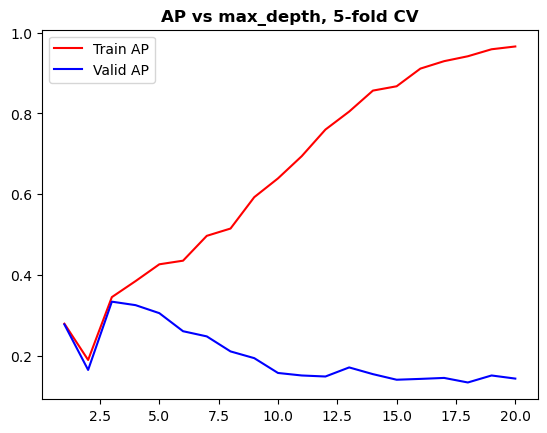

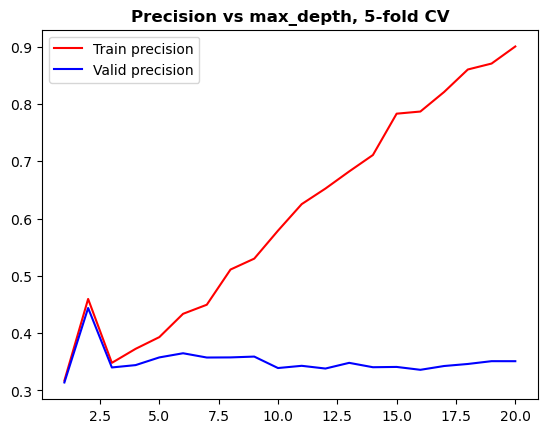

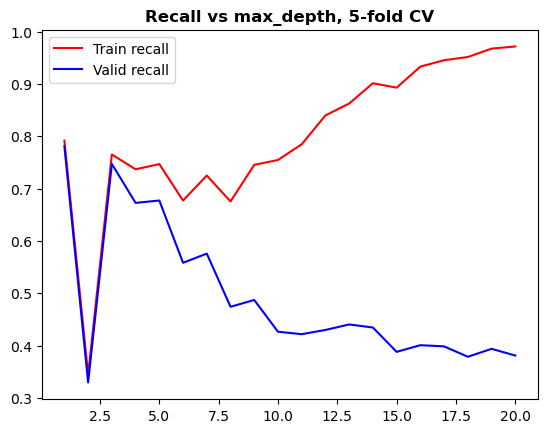

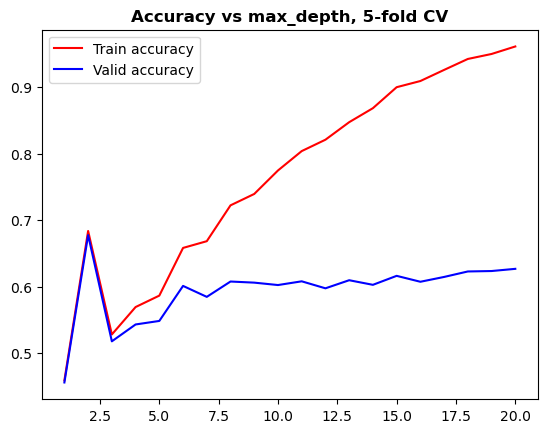

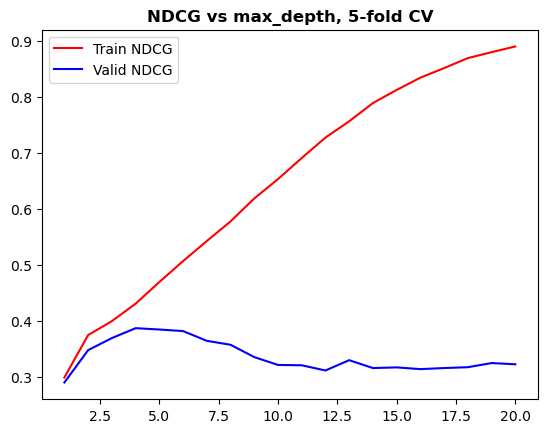

0.3255669778953992
0.38757157111093127


In [16]:
# Model 2 - class adjustment
dataset = loadDataset()

depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

train_ap = []
valid_ap = []

train_precision = []
valid_precision = []

train_recall = []
valid_recall = []

train_acc = []
valid_acc = []

train_ndcg = []
valid_ndcg = []

for d in depth:
    letor_model = LETOR(dataset, trials, class_weight="balanced", sample_weight=None, max_d = d)
    metrics, confusion_matrix_train, confusion_matrix_valid = letor_model.obtainCVmetrics()
    print(d)
    print("Train: ")
    print(confusion_matrix_train)
    print("Valid:")
    print(confusion_matrix_valid)
    
    train_ap.append(metrics[1, 0])
    valid_ap.append(metrics[1, 1])

    train_precision.append(metrics[0, 0])
    valid_precision.append(metrics[0, 1])
    
    train_recall.append(metrics[2, 0])
    valid_recall.append(metrics[2, 1])
    
    train_acc.append(metrics[3, 0])
    valid_acc.append(metrics[3, 1])
    
    train_ndcg.append(metrics[4, 0])
    valid_ndcg.append(metrics[4, 1])

C_values = depth
    
plt.figure()
plt.plot(C_values, train_ap, 'r')
plt.plot(C_values, valid_ap, 'b')
plt.legend(['Train AP', 'Valid AP'])
plt.title('AP vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_precision, 'r')
plt.plot(C_values, valid_precision, 'b')
plt.legend(['Train precision', 'Valid precision'])
plt.title('Precision vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_recall, 'r')
plt.plot(C_values, valid_recall, 'b')
plt.legend(['Train recall', 'Valid recall'])
plt.title('Recall vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_acc, 'r')
plt.plot(C_values, valid_acc, 'b')
plt.legend(['Train accuracy', 'Valid accuracy'])
plt.title('Accuracy vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_ndcg, 'r')
plt.plot(C_values, valid_ndcg, 'b')
plt.legend(['Train NDCG', 'Valid NDCG'])
plt.title('NDCG vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

print(valid_ap[3])
print(valid_ndcg[3])

1
Train: 
[[2741. 5975.]
 [ 677. 2755.]]
Valid:
[[ 687. 1492.]
 [ 177.  681.]]
2
Train: 
[[2055. 6661.]
 [ 377. 3055.]]
Valid:
[[ 488. 1691.]
 [ 113.  745.]]
3
Train: 
[[2810. 5906.]
 [ 483. 2949.]]
Valid:
[[ 678. 1501.]
 [ 148.  710.]]
4
Train: 
[[3318. 5398.]
 [ 570. 2862.]]
Valid:
[[ 808. 1371.]
 [ 185.  673.]]
5
Train: 
[[3391. 5325.]
 [ 492. 2940.]]
Valid:
[[ 799. 1380.]
 [ 187.  671.]]
6
Train: 
[[3510. 5206.]
 [ 433. 2999.]]
Valid:
[[ 812. 1367.]
 [ 193.  665.]]
7
Train: 
[[3759. 4957.]
 [ 378. 3054.]]
Valid:
[[ 848. 1331.]
 [ 203.  655.]]
8
Train: 
[[4129. 4587.]
 [ 302. 3130.]]
Valid:
[[ 911. 1268.]
 [ 214.  644.]]
9
Train: 
[[4586. 4130.]
 [ 322. 3110.]]
Valid:
[[ 992. 1187.]
 [ 254.  604.]]
10
Train: 
[[4923. 3793.]
 [ 265. 3167.]]
Valid:
[[1048. 1131.]
 [ 273.  585.]]
11
Train: 
[[5410. 3306.]
 [ 268. 3164.]]
Valid:
[[1127. 1052.]
 [ 324.  534.]]
12
Train: 
[[5738. 2978.]
 [ 226. 3206.]]
Valid:
[[1165. 1014.]
 [ 347.  511.]]
13
Train: 
[[6233. 2483.]
 [ 248. 3184.]]
Valid:


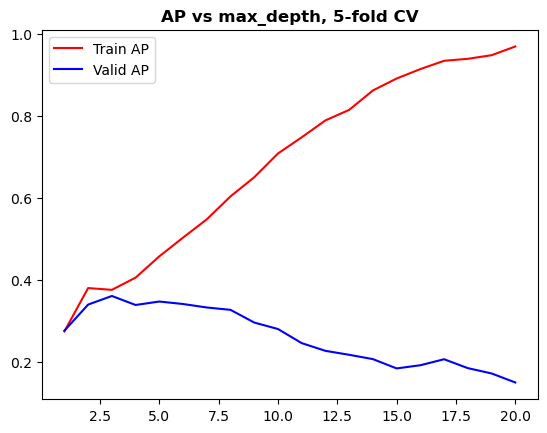

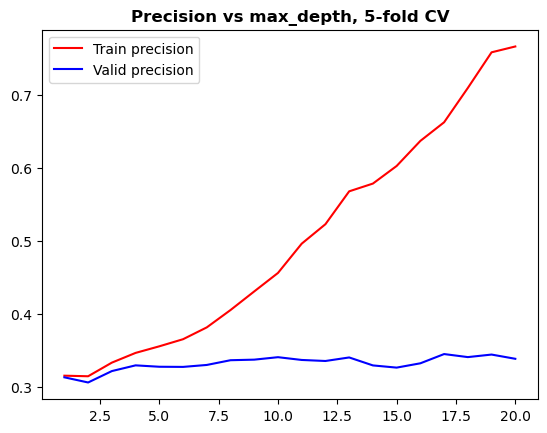

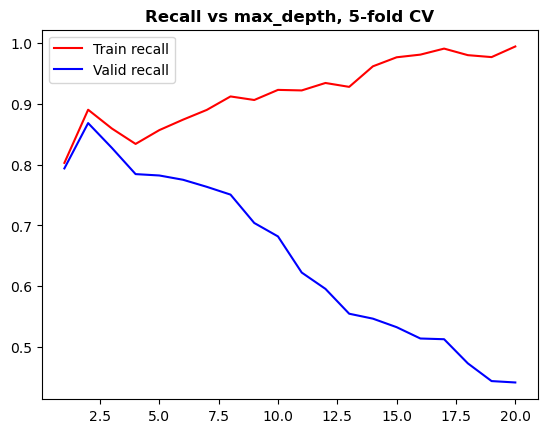

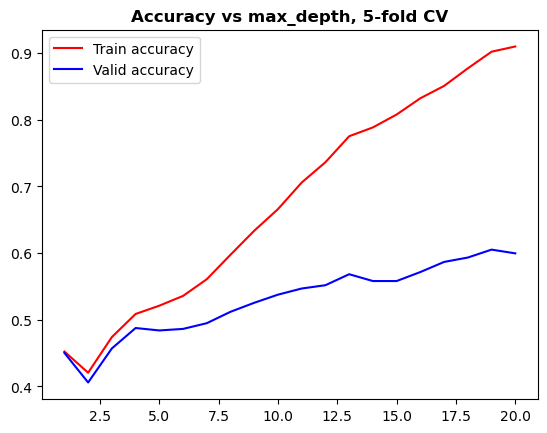

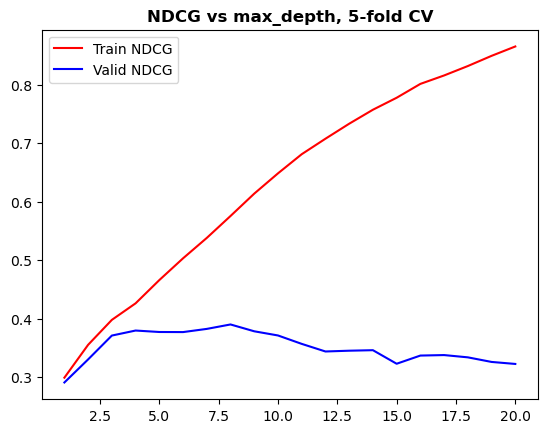

0.3385464526413511
0.3795416435582014


In [17]:
# Model 3 - all adjustment
dataset = loadDataset()

depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

train_ap = []
valid_ap = []

train_precision = []
valid_precision = []

train_recall = []
valid_recall = []

train_acc = []
valid_acc = []

train_ndcg = []
valid_ndcg = []

for d in depth:
    letor_model = LETOR(dataset, trials, class_weight="balanced", sample_weight="relevance", max_d = d)
    metrics, confusion_matrix_train, confusion_matrix_valid = letor_model.obtainCVmetrics()
    print(d)
    print("Train: ")
    print(confusion_matrix_train)
    print("Valid:")
    print(confusion_matrix_valid)
    
    train_ap.append(metrics[1, 0])
    valid_ap.append(metrics[1, 1])

    train_precision.append(metrics[0, 0])
    valid_precision.append(metrics[0, 1])
    
    train_recall.append(metrics[2, 0])
    valid_recall.append(metrics[2, 1])
    
    train_acc.append(metrics[3, 0])
    valid_acc.append(metrics[3, 1])
    
    train_ndcg.append(metrics[4, 0])
    valid_ndcg.append(metrics[4, 1])

C_values = depth
    
plt.figure()
plt.plot(C_values, train_ap, 'r')
plt.plot(C_values, valid_ap, 'b')
plt.legend(['Train AP', 'Valid AP'])
plt.title('AP vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_precision, 'r')
plt.plot(C_values, valid_precision, 'b')
plt.legend(['Train precision', 'Valid precision'])
plt.title('Precision vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_recall, 'r')
plt.plot(C_values, valid_recall, 'b')
plt.legend(['Train recall', 'Valid recall'])
plt.title('Recall vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_acc, 'r')
plt.plot(C_values, valid_acc, 'b')
plt.legend(['Train accuracy', 'Valid accuracy'])
plt.title('Accuracy vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

plt.figure()
plt.plot(C_values, train_ndcg, 'r')
plt.plot(C_values, valid_ndcg, 'b')
plt.legend(['Train NDCG', 'Valid NDCG'])
plt.title('NDCG vs max_depth, 5-fold CV', fontweight='bold')
plt.show()

print(valid_ap[3])
print(valid_ndcg[3])

Feature importances

In [19]:
letor_model.classifier.features_importances_

array([0.02576761, 0.16031451, 0.01270711, 0.19371322, 0.0141327 ,
       0.30318531, 0.06375241, 0.22642713])

Evaluation of the final model on train, without filters

In [18]:
dataset = loadDataset()

letor_model = LETOR(dataset, trials, class_weight='balanced', sample_weight='relevance', max_d=5)
letor_model.fitModel()

df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = letor_model.get_top_query_results(query, gender_filter = False, age_filter = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print(df_metrics.loc['average'])

if False:
    model_data = open('baseline 1.obj', 'wb')
    pickle.dump(df_metrics, model_data)
    model_data.close()

P@10                                                           0.119149
recall                                                         0.377281
AP                                                             0.097531
NDCG5                                                          0.154465
MRR                                                            0.005035
11-point-precision    [0.32475171668256314, 0.2401041299560355, 0.15...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object


Evaluation with different filters' configurations

In [3]:
dataset = loadDataset()

letor_model = LETOR(dataset, trials, class_weight='balanced', sample_weight='relevance', max_d=5)
letor_model.fitModel()

df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = letor_model.get_top_query_results(query, gender_filter = False, age_filter = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("No filters")
print(df_metrics.loc['average'])
print("\n")


df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = letor_model.get_top_query_results(query, gender_filter = True, age_filter = False)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("Gender filter on")
print(df_metrics.loc['average'])
print("\n")


df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = letor_model.get_top_query_results(query, gender_filter = False, age_filter = True)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("Age filter on")
print(df_metrics.loc['average'])
print("\n")


df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = letor_model.get_top_query_results(query)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print("All filters on")
print(df_metrics.loc['average'])

No filters
P@10                                                           0.119149
recall                                                         0.377281
AP                                                             0.097531
NDCG5                                                          0.154465
MRR                                                            0.005035
11-point-precision    [0.32475171668256314, 0.2401041299560355, 0.15...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object


Gender filter on
P@10                                                           0.121277
recall                                                         0.378691
AP                                                             0.096843
NDCG5                                                           0.15307
MRR                                                            0.005035
11-point-precision    [0.32532546262544204, 0.2423649541385865, 0.14...
11-po

Final evaluation of the models

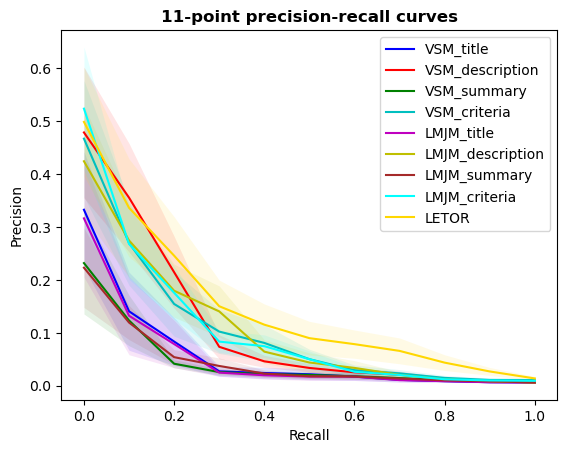

In [5]:
if (exists('vsm_models.obj') and exists('lmjm_models.obj')):    
        #load the objects from pickle
        file_data = open('vsm_models.obj', 'rb') 
        VSM_models = pickle.load(file_data)
        file_data.close()
    
        file_data = open('lmjm_models.obj', 'rb') 
        LMJM_models = pickle.load(file_data)
        file_data.close()
        
base_models = [*VSM_models, *LMJM_models]

dataset = loadDataset()

letor_model = LETOR(dataset, trials, class_weight='balanced', sample_weight='relevance', max_d=5)
letor_model.fitModel()


test_metrics = pd.DataFrame(data=None, columns = ['11-point-precision', '11-point-recall',
                                                     'se-precision', 'se-recall'])

for idx, model in enumerate(base_models):
    df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
    for query in test:
        search_results = model.get_top_query_results(query.query_content)
        eval = Evaluate(query, search_results)
    
        df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                          eval.mrr, eval.precision_11point, eval.recall_11point]

    df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                 df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                 df_metrics['MRR'].mean(), 
                                 np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                 np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
    print(df_metrics.loc['average'])
    
    std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
    se_recall = std_recall/np.sqrt(len(test))

    std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
    se_precision = std_precision/np.sqrt(len(test))
    
    test_metrics.loc[idx] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]

# Now LETOR model
df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in test:
    search_results = letor_model.get_top_query_results(query)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                        eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                                df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                                df_metrics['MRR'].mean(), 
                                np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                                np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]
print(df_metrics.loc['average'])
    
std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
se_recall = std_recall/np.sqrt(len(test))

std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
se_precision = std_precision/np.sqrt(len(test))
    
test_metrics.loc[8] = [df_metrics.loc['average']['11-point-precision'],
                                   df_metrics.loc['average']['11-point-recall'],
                                   se_precision, se_recall]
    
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'brown', 'aqua', 'gold']
    
for i in range(0, 9):   
    plt.plot(test_metrics.loc[i]['11-point-recall'],
             test_metrics.loc[i]['11-point-precision'], color = colors[i])

    plt.fill_between(test_metrics.loc[i]['11-point-recall'],
                     test_metrics.loc[i]['11-point-precision'] - test_metrics.iloc[i]['se-precision'],
                     test_metrics.loc[i]['11-point-precision'] + test_metrics.iloc[i]['se-precision'],
                     alpha = 0.1, color=colors[i], linewidth = 0, label='_nolegend_')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-point precision-recall curves', fontweight='bold')
plt.legend(['VSM_title', 'VSM_description', 'VSM_summary', 'VSM_criteria',
            'LMJM_title', 'LMJM_description', 'LMJM_summary', 'LMJM_criteria',
            'LETOR'])

In [ ]:
Failure analysis

In [9]:
dataset = loadDataset()

letor_model = LETOR(dataset, trials, class_weight='balanced', sample_weight='relevance', max_d=5)
letor_model.fitModel()

df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])
for query in train:
    search_results = letor_model.get_top_query_results(query)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

Text(0, 0.5, 'MAP')

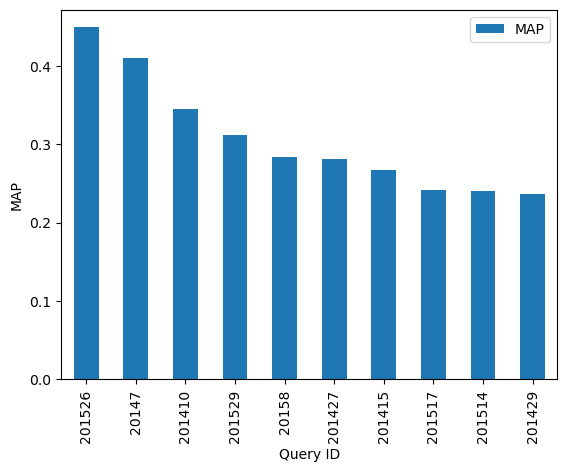

In [19]:
df_metrics = df_metrics.rename(columns={"AP": "MAP"})
ax = df_metrics.nlargest(10, 'MAP').plot.bar(y = 'MAP')
ax.set_xlabel("Query ID")
ax.set_ylabel("MAP")

In [44]:
ids = np.array([query.query_id for query in train])

queries = ['201526', '20147', '201410', '201529', '20158', '201427', '201415', '201517', '201514', '201429']

for q in queries:
    i = np.where(ids == q)[0][0]
    print(train[i].query_content)

An obese 28 yo female with non-ruptured ectopic pregnancy and history of adhesions.
       		
26-year-old obese woman with bipolar disorder, on zolpidem and lithium, with recent difficulty sleeping, agitation, suicidal ideation, and irritability.
       		
67-year-old woman status post cardiac catheterization via right femoral artery, now with a cool, pulseless right foot and right femoral bruit.
       		
A 4-year-old girl with persistent high fever, skin rash, strawberry tongue, swollen red hands, and bilateral nonexudative conjunctivitis.
       		
A 10-year-old boy with difficulty concentrating, daytime sleepiness, and failure to thrive. The boy sleeps restlessly, snores, sweats, breathes heavily through his mouth and gasps in his sleep. 
       		
21-year-old male with dozens of small polyps found on colonoscopy. Family history significant for both older siblings having total colectomies after colonoscopy revealed hundreds of adenomas.
       		
36-year-old woman with amenorrhea, 

Text(24.000000000000007, 0.5, 'MAP')

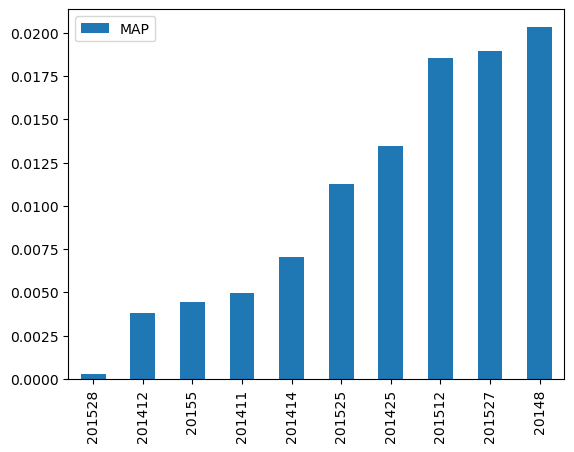

In [21]:
df_metrics = df_metrics.rename(columns={"AP": "MAP"})
df_metrics.nsmallest(10, 'MAP').plot.bar(y = 'MAP')
ax.set_xlabel("Query ID")
ax.set_ylabel("MAP")

In [45]:
ids = np.array([query.query_id for query in train])

queries = ['201528', '201412', '20155', '201411', '201414', '201525', '201425', '201512', '201527', '20148']

for q in queries:
    i = np.where(ids == q)[0][0]
    print(train[i].query_content)

An 8-year-old boy presents with a swollen right knee, lower extremity pain and fever. The parents report no history of trauma. The parents noticed a tick bite several months earlier.
       		
25-year-old woman with fatigue, hair loss, weight gain, and cold intolerance for 6 months.
       		
Young adult woman with 2 weeks of fever and migrating joint inflammation.
       		
40-year-old woman with severe right arm pain and hypotension. She has no history of trauma and right arm exam reveals no significant findings.
       		
85-year-old man who was in a car accident 3 weeks ago, now with 3 days of progressively decreasing level of consciousness and impaired ability to perform activities of daily living.
       		
10-year-old boy with progressive right knee and left leg pain and edema, lethargy and an osteolytic lesion. No history of trauma, fever, tachycardia, or urinary incontinence.
       		
8-year-old boy with decreased level of consciousness 30 minutes after falling from his bike 